# `CLEMnet` preview and predictions on RL012
---
#### Overview
* Model for typical previewing RL012 and predicting on RL012
    * qualitatively
    * quantitatively

In [1]:
# device = cuda.get_current_device()
# device.reset()

In [2]:
import clemnet

In [3]:
from pathlib import Path
import random
from datetime import datetime
from numba import cuda 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tabulate import tabulate

from skimage import io, exposure, color
from skimage import img_as_ubyte, img_as_float
from skimage.util import invert, crop
from skimage.transform import resize
from sklearn import preprocessing

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Set GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Set colormap
plt.set_cmap('magma')
plt.close();

# Ignore annoying Futurewarning from `gray2rgba`
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set ... AUTOTUNE?
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Initiating code for GetModel() for predicting
---

In [4]:
# 20200618_RL012
# --------------
fps_src = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
fps_tgt = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

fps_src = list(Path('/home/rlane/FMML_DATA/20211206_RP_OTO/lil_EM_montaged/').glob('*/*_*_*.png'))


# Get DataFrame for training
df_trn = clemnet.get_DataFrame(fps_src, fps_tgt)

# Filter out all but 0th zoom level
df_trn = df_trn.loc[df_trn['zoom'] == 0]
# Filter out a test section
df_trn = df_trn.loc[df_trn['z'] != 7]

# Filter out outermost rows and columns
# where data is poor or does not exist
b = 4
df_trn_RL012 = pd.DataFrame()

# Must be done per section
for z, grp in df_trn.groupby('z'):
    df_trn_RL012 = df_trn_RL012.append(grp.loc[(grp['x'] > grp['x'].min()+b) &\
                                               (grp['y'] > grp['y'].min()+b) &\
                                               (grp['x'] < grp['x'].max()-b) &\
                                               (grp['y'] < grp['y'].max()-b)])
# print(df_trn_RL012)

In [5]:
# Combine and shuffle DataFrame
df_trn = pd.concat([df_trn_RL012])
df_trn = df_trn.sample(frac=1, random_state=1337).reset_index(drop=True)

# Set source and target filepaths
fps_src = df_trn['source'].values
fps_tgt = df_trn['target'].values

# Preview
out = f"""\
Number of training images... {len(df_trn)}
--------""";print(out)
# df_trn.sample(10)

Number of training images... 334
--------


### Create training and validation datasets
First test with very limited dataset size

In [6]:
# Choose validation size
n_validation = int(0.2 * len(df_trn))

# Split into training and validation sets
fps_trn_src = fps_src[:-n_validation]
fps_trn_tgt = fps_tgt[:-n_validation]
fps_val_src = fps_src[-n_validation:]
fps_val_tgt = fps_tgt[-n_validation:]

In [7]:
# Set training parameters
repeat = True
n_repetitions = 4
shape_src = [1024, 1024]
shape_tgt = [256, 256]
augment = True
AUGMENTATIONS = {
    'flip': 1,
    'rotate': 1,
    'crop': 0.,
    'elastic': 0.3,
    'invert': 0.,
    'contrast': 0.3,
    'brightness': 0.3,
    'noise': 0.,
}
pad = False
padding = tf.constant([[16, 16],
                       [16, 16],
                       [ 0,  0]])
batch_size = 16
n_cores = 4

# Create datasets
ds_trn = clemnet.create_dataset(fps_trn_src, fps_trn_tgt, shuffle=False, buffer_size=None,
                                repeat=repeat, n_repetitions=n_repetitions, shape_src=shape_src,
                                shape_tgt=shape_tgt, augment=augment, augmentations=AUGMENTATIONS,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)
ds_val = clemnet.create_dataset(fps_val_src, fps_val_tgt, shuffle=False, buffer_size=None,
                                repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)

# Get first batch for shape info
batch_EM, batch_FM = next(iter(ds_trn))

print(f"""\
Training dataset size..... {tf.data.experimental.cardinality(ds_trn).numpy()}
Validation dataset size... {tf.data.experimental.cardinality(ds_val).numpy()}
EM image shape............ {batch_EM.shape}
FM image shape............ {batch_FM.shape}""")

2022-03-11 04:18:05.074603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-11 04:18:06.277462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-03-11 04:18:06.278522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-03-11 04:18:06.279419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41G

Training dataset size..... 67
Validation dataset size... 5
EM image shape............ (16, 1024, 1024, 1)
FM image shape............ (16, 256, 256, 1)


### Preview dataset

In [8]:
# # Set up figure
# %matplotlib inline
# ncols = 4
# nrows = int(np.ceil(batch_size / ncols))
# fig = plt.figure(figsize=(ncols*9, nrows*3))
# gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
#                        hspace=0.08, wspace=0.05)

# # Loop through a batch size worth of images
# batch_EM, batch_FM = next(iter(ds_trn))
# for i in tqdm(range(batch_size)):

#     # Fetch images from batch
#     img_EM = batch_EM[i,:,:,0].numpy().astype(np.float32)
#     img_FM = batch_FM[i,:,:,0].numpy().astype(np.float32)
#     # Upsample to fit EM
#     img_FM = resize(img_FM, img_EM.shape)

#     # Create CLEM image
#     img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
#     img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
#     img_CLEM = exposure.rescale_intensity(img_EM_+img_FM_, in_range=(0, 1))

#     # Set up mini gridspec
#     gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, wspace=0,
#                                            subplot_spec=gs[i])
#     ax1 = fig.add_subplot(gss[0])
#     ax2 = fig.add_subplot(gss[1])
#     ax3 = fig.add_subplot(gss[2])

#     # Plot images
#     ax1.imshow(img_EM, cmap='gray', vmin=0, vmax=1)
#     ax2.imshow(img_FM, cmap='magma', vmin=0, vmax=1)
#     ax3.imshow(img_CLEM)

#     # Aesthetics
#     [ax.axis('off') for ax in [ax1, ax2, ax3]]

In [9]:
%load_ext tensorboard

### Create model
Need better resolution for insulin prediction

In [10]:
def get_model(input_shape=(1024, 1024), crop_=False, crop_width=None):
    """U-net-like convolutional neural network
    Parameters
    ----------
    input_shape : tuple
        Shape of input image data
    crop : bool
        Whether to include a cropping layer
    crop_width : int
        Number of pixels to crop from each border

    Returns
    -------
    model : `keras.Model`
        The model (duh)

    References
    ----------
    [1] U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    [2] Adapted from
        https://github.com/zhixuhao/unet/blob/master/model.py
    """
    # Create input layer
    input_shape = (*input_shape, 1) if len(input_shape) < 3 else input_shape
    inputs = layers.Input(shape=input_shape)

    # Set up keyword arguments for convolutional layers
    kwargs = {
        'activation': 'relu',
        'padding': 'same',
        'kernel_initializer': 'he_normal'
    }

    # Downsampling arm
    # ----------------
    # Block 1
    conv1 = layers.Conv2D(32, 3, **kwargs)(inputs)
    pool1 = layers.MaxPooling2D(2)(conv1)
    # Block 2
    conv2 = layers.Conv2D(64, 3, **kwargs)(pool1)
    pool2 = layers.MaxPooling2D(2)(conv2)
    # Block 3
    conv3 = layers.Conv2D(128, 3, **kwargs)(pool2)
    pool3 = layers.MaxPooling2D(2)(conv3)
    # Block 4
    conv4 = layers.Conv2D(256, 3, **kwargs)(pool3)
    pool4 = layers.MaxPooling2D(2)(conv4)
    # Block 5
    conv5 = layers.Conv2D(512, 3, **kwargs)(pool4)
    pool5 = layers.MaxPooling2D(2)(conv5)
    # Block 6
    conv6 = layers.Conv2D(1024, 3, **kwargs)(pool5)
    pool6 = layers.MaxPooling2D(2)(conv6)

    # Upsampling arm
    # --------------
    # Block 7
    conv7 = layers.Conv2D(1024, 3, **kwargs)(pool6)
    uppp7 = layers.UpSampling2D(2)(conv7)
    # Block 8
    merg8 = layers.concatenate([conv6, uppp7], axis=3)
    conv8 = layers.Conv2D(1024, 3, **kwargs)(merg8)
    uppp8 = layers.UpSampling2D(2)(conv8)
    # Block 9
    merg9 = layers.concatenate([conv5, uppp8], axis=3)
    conv9 = layers.Conv2D(512, 3, **kwargs)(merg9)
    uppp9 = layers.UpSampling2D(2)(conv9)
    # Block 10
    merg10 = layers.concatenate([conv4, uppp9], axis=3)
    conv10 = layers.Conv2D(256, 3, **kwargs)(merg10)
    conv10 = layers.Conv2D(2, 3, **kwargs)(conv10)

    # Additional upsampling
    uppp11 = layers.UpSampling2D(2)(conv10)

    # Output layer
    conv11 = layers.Conv2D(1, 1, activation='sigmoid')(uppp11)
    model = keras.Model(inputs=inputs, outputs=conv11)
    return model

In [11]:
# Get input shape for model
input_shape = batch_EM.shape[1:-1]

# Get model
crop_ = pad
crop_width = 16
model = get_model(input_shape=input_shape,
                  crop_=crop_, crop_width=crop_width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Train

In [12]:
# Check if batch size is appropriate
batch_size_max = clemnet.get_max_batch_size(12, model)
print(f"""\
Current batch size... {batch_size}
Max batch size....... {int(np.floor(batch_size_max))}
Good to go..........? {batch_size <= batch_size_max}""")

Current batch size... 16
Max batch size....... 18
Good to go..........? True


### Compile model

In [13]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[clemnet.PCC_tf, clemnet.ICQ_tf])

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Model
model_name = 'RL012_1024x1024_hoechst'

# Set callbacks
fp_weights = Path(f"./weights/{model_name}_{timestamp}.h5")
fp_logs = Path(f"./logs/{model_name}_{timestamp}")
fp_weights.parent.mkdir(parents=True, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(fp_weights.as_posix(),
                                    save_best_only=True,
                                    save_weights_only=True),
    keras.callbacks.TensorBoard(log_dir=fp_logs.as_posix()),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=15,
                                  verbose=1)
]

out = f"""\
Saving model to... {fp_weights}
Saving logs to.... {fp_logs}"""
print(out)

Saving model to... weights/RL012_1024x1024_hoechst_20220311_041834.h5
Saving logs to.... logs/RL012_1024x1024_hoechst_20220311_041834


2022-03-11 04:18:34.186823: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-03-11 04:18:34.186916: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 4 GPUs
2022-03-11 04:18:34.190543: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcupti.so.10.1
2022-03-11 04:18:34.590296: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1479] CUPTI activity buffer flushed


## Testing
---

### Create test dataset

In [14]:
xy_maxmin = pd.DataFrame()

##### Choose dataset & zoom_level

In [15]:
# 20200618_RL012
# --------------
fp_src = '/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/'
fps_src_Rl012 = list(Path(fp_src).glob('*/*_*_*.png'))
# fps_src_RL012_mask = list(Path('/home/mabels/CLEMnet/data/RL012/masks_MA/1/').glob('*/*_*_*.png'))
fps_tgt_RL012 = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

zoom_level_init = 0 

In [16]:
# Get DataFrame for predicting

# ---------------------------------------------------------
df_tst = clemnet.get_DataFrame(fps_src_Rl012, fps_tgt_RL012)
# ----------------------------------------------------------

# xy_maxmin for all #i zoom_levels
for i in df_tst['zoom'].unique():
    df_tst = clemnet.get_DataFrame(fps_src_Rl012)
    df_tst = df_tst.loc[df_tst['zoom'] == i]  
    xy_maxmin[i] = [(df_tst['x'].unique().min() if df_tst['x'].unique().min() != 0 else 1), 
                    df_tst['x'].unique().max(), 
                    (df_tst['y'].unique().min() if df_tst['y'].unique().min() != 0 else 1), 
                    df_tst['y'].unique().max()]


print(xy_maxmin)    
# Get DataFrame for predicting
# ---------------------------------------------------------
df_tst = clemnet.get_DataFrame(fps_src_Rl012, fps_tgt_RL012)
# ----------------------------------------------------------

# df_tst_mask = clemnet.get_DataFrame(fps_src_RL012_mask)

df_tst = df_tst.loc[df_tst['zoom'] == zoom_level_init]
# df_tst_mask = df_tst_mask.loc[df_tst_mask['zoom'] == zoom_level_init]
# Filter out a test section
df_tst = df_tst.loc[(df_tst['z'] == 1)]
# df_tst_mask = df_tst_mask.loc[(df_tst_mask['z'] == 1)]

# Filter out outermost rows and columns
# where data is poor or does not exist
b = 0
df_tst_filtered = pd.DataFrame()
# df_tst_filtered_mask = pd.DataFrame()

# # Must be done per section, first x, than y
fltr  = pd.DataFrame()

# [[[x0, x1], [y0, y1]]]
fltr_manual = [[[0, xy_maxmin[zoom_level_init][1]], 
                [0, xy_maxmin[zoom_level_init][3]]]]

# ---------------------------------------------------------
fltr_manual = [[16, 31], [16, 31]]    # zoom_level = 0
# fltr_manual = [[18, 19], [18, 18]]    # zoom_level = 0
# fltr_manual = [[8, 15], [8, 15]]    # zoom_level = 1
# fltr_manual = [[8, 9], [8, 9]]    # zoom_level = 1
# ---------------------------------------------------------

# Nucleus
# ---------------------------------------------------------
# fltr_manual = [[20, 24], [20, 24]]    # zoom_level = 0
# ---------------------------------------------------------

for i, (z, grp) in enumerate(df_tst.groupby('z')):
                
    df_tst_filtered = df_tst_filtered.append(grp.loc[(grp['x'] >= grp['x'].min()+b) &\
                                               (grp['y'] >= grp['y'].min()+b) &\
                                               (grp['x'] <= grp['x'].max()-b) &\
                                               (grp['y'] <= grp['y'].max()-b) &\
                                               (grp['x'] >= fltr_manual[0][0]) &\
                                               (grp['x'] <= fltr_manual[0][1]) &\
                                               (grp['y'] >= fltr_manual[1][0]) &\
                                               (grp['y'] <= fltr_manual[1][1])])
    
    
print()
print(df_tst_filtered)
pd.set_option('display.max_colwidth', -1)

   3  4  5  6   0   1   2
0  1  1  1  1   3   1   1
1  5  2  1  0  40  20  10
2  1  1  1  1   3   1   1
3  5  2  1  0  42  21  10

                                                source  z   y   x  zoom  \
346  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  16  16     0   
348  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  16  17     0   
350  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  16  18     0   
352  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  16  19     0   
354  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  16  20     0   
..                                                 ... ..  ..  ..   ...   
991  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  31  27     0   
992  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  31  28     0   
993  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  31  29     0   
994  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  31  30     0   
995  /home/rlane/FMML_DATA/20200618_RL012/2u

/tmp/ipykernel_82843/3284407100.py:70: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Dataset preview

  0%|          | 0/256 [00:00<?, ?it/s]

min: 0.0 max: 1.0


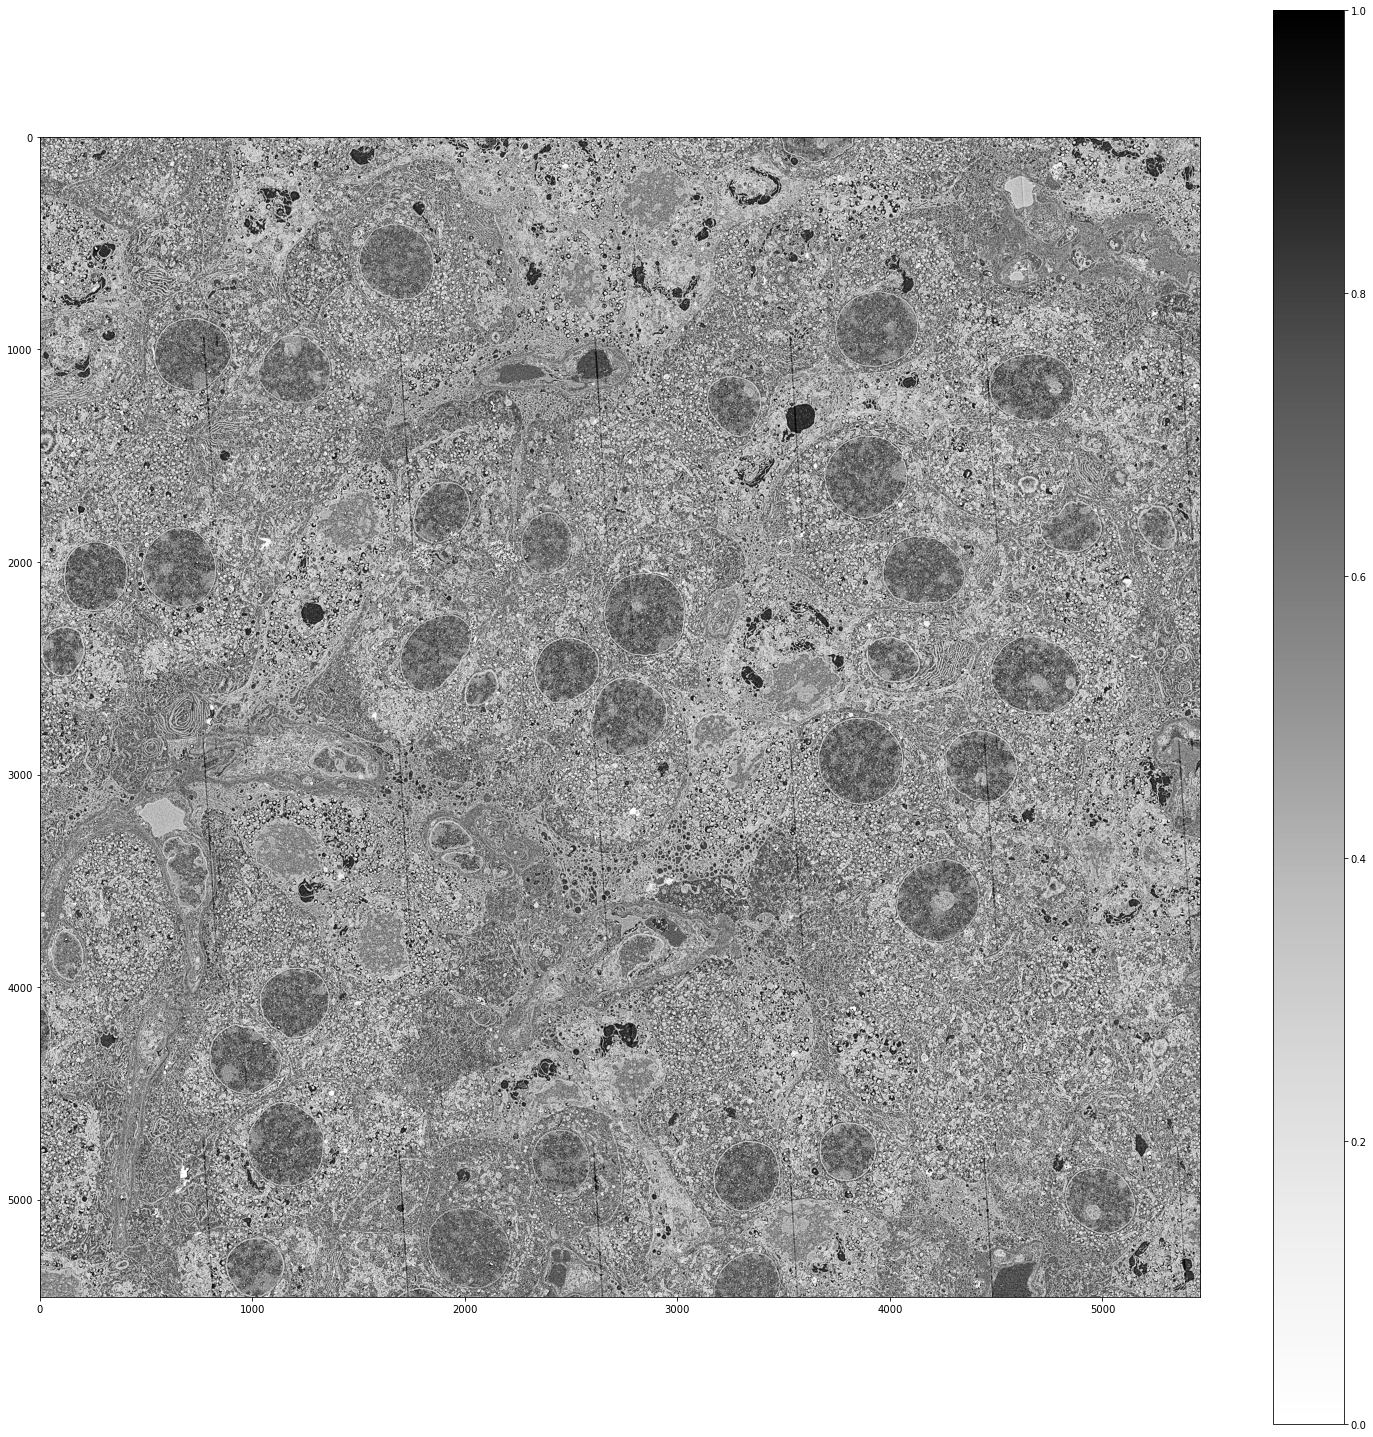

In [17]:
# Make figure
%matplotlib inline
ncols = df_tst_filtered['z'].unique().size
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(26*ncols, 26),
                         sharex=True, sharey=True, squeeze=False)
axmap = {k:v for k,v in zip(df_tst['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):
    
    # Create dataset for section
    fps_tst_src = df_sec['source']
    fps_tst_tgt = df_sec['target']
    ds_section = clemnet.create_dataset(fps_tst_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt,
                                        augment=True, augmentations={'invert': True},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()
    
    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))   
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])
    section_EM = np.empty(shape)

    # Loop through individual EM 
    for (i, row), (batch_EM) in tqdm(zip(df_sec.iterrows(), ds_section), total=len_ds):
         
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        

        # Populate section images
        section_EM[y1:y2, x1:x2] = batch_EM[0,:,:,0]

        
#     # Colorize and overlay section images & Plot
#     section_EM = color.gray2rgba(invert(section_EM), alpha=True)
    print('min:', section_EM.min(), 'max:', section_EM.max())

    output_shape = [d//3 for d in section_EM.shape[:2]]
    im = axmap[z][0].imshow(resize(section_EM, output_shape), cmap='Greys')
    plt.colorbar(im)
#     axmap[z][1].imshow(resize(section_EM, output_shape), cmap='Greys')

## Make predictions

### Normalizations and Adjustments

In [18]:
def mean_std_adjustments(m0, s0, m1, s1, image):
    std_factor = s1/s0
    mean_adjustment = m1-m0
    image = image+mean_adjustment
    image = tf.image.adjust_contrast(image[:,:,np.newaxis], std_factor)
    image = image.numpy()[:,:,0]
    return image

In [19]:
# Adjustments Training Dataset (preview!)
adjust_blur_tds = False


# Adustments Predic Dataset
everything = 0
# everything = 1
# everything = ''

if everything==0:
    adjust_PIL = False
    adjust_invert = False
    adjust_sharpness = False
    adjust_contrast = False
    adjust_mean_std = False
    adjust_clipping = False
elif everything==1:
    adjust_PIL = True
    adjust_invert = True
    adjust_sharpness = True
    adjust_contrast = True
    adjust_mean_std = True
    adjust_clipping = True
else:
    adjust_PIL = True
    adjust_invert = True
    adjust_sharpness = True
    adjust_contrast = True
    adjust_mean_std = True
    adjust_clipping = True
    
preview_prediction = False

adjust_sharpness_level = (4 if adjust_sharpness else 0)
adjust_contrast_level = (1.2 if adjust_contrast else 0)

# RL012 and FASTEM mu & sigma
std_RL012 = 0.287
std_OSTEM = 0.134
mean_RL012 = 0.462
mean_OSTEM = 0.644

mean_3 = 0
sigma_3 = 1

threshold_mask = True
threshold_val = 0.01

### Load Weights and make Prediction


In [20]:
# Load weights
# fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel1_20211118_003159.h5')
fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel_0_20211214_083058.h5')

model.load_weights(fp_weights.as_posix())

# # Load weights_blurred
# fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel_1_blurred_20211124_103409.h5')
# model.load_weights(fp_weights.as_posix())

In [98]:
# data = pd.read_csv(r'./quant_analysis.csv')
# df = pd.DataFrame(data)
# df

# Make new excel file
# -------------------
# df = pd.DataFrame()

In [99]:
# df.drop(df.tail(2).index,inplace=True)
# df
# df.to_csv('quant_analysis.csv', index=False)

### Full section prediction

In [21]:
# print('BSE Mean:', img_BSE.mean(), 'BSE Std:', img_BSE.std())
# print('OSTEM Mean:', img_OSTEM.mean(), 'OSTEM Std:', img_OSTEM.std())
print()
print('Inverted:            ', adjust_invert)
print('Sharpness:           ', adjust_sharpness,'(level:',adjust_sharpness_level,')')
print('Contrast:            ', adjust_contrast,'(level:',adjust_contrast_level,')')
print('Mean & Std:          ', adjust_mean_std)
print('Clipping:            ', adjust_clipping)
print()
print('Threshold:            ', threshold_val)

# Make figure
%matplotlib widget
# ncols = df_tst_filtered['z'].unique().size
# fig, axes = plt.subplots(ncols=ncols, nrows=3, figsize=(6*ncols, 12),
#                          sharex=True, sharey=True, squeeze=False)
# axmap = {k:v for k,v in zip(df_tst_filtered['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):
    
    # Create dataset for section
    fps_src = df_sec['source']

    ds_section = clemnet.create_dataset(fps_src, fps_tst_tgt, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=True, augmentations={'invert': True},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()

    # Create empty arrays for full section images
    (batch_EM, batch_FM) = next(iter(ds_section))
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])

    section_EM = np.empty(shape)
#     section_EM_blurred = np.empty(shape)
    section_PR = np.empty(shape)
    section_mask = np.empty(shape)
    section_PR_thres_1 = np.empty(shape)
    section_PR_thres_2 = np.empty(shape)

    # Loop through individual EM and FM tiles
    
    # ---------------------------------------------------------------
    for (i, row), (batch_EM, batch_FM) in tqdm(zip(df_sec.iterrows(), ds_section),
                                               total=len_ds):
        # ---------------------------------------------------------------
        fps_src_mask = "/home/mabels/CLEMnet/data/RL012/masks_MA/1/1/1_1_4.png"
        img_mask = Image.open(fps_src_mask)
        
        img_mask = np.asarray(img_mask)/255
        scale = 64
        y = (row['y']-fltr_manual[1][0])*scale
        x = (row['x']-fltr_manual[0][0])*scale
        w = scale
        h = scale
        
        img_mask = img_mask[y:y+h, x:x+w, 0]
        img_mask = resize(img_mask, (1024,1024))
        img_mask = img_mask[:,:]*-1+1
        
        # -------------------------------------        
        img_OSTEM = batch_EM[0,:,:,0].numpy()
        img_FM = batch_FM[0,:,:,0].numpy().astype(np.float32)
        # -------------------------------------
        
#         img_BSE_blurred = img_as_float(io.imread(fps_BSE_blurred[i]))
        
        # Image PIL enhancements: Sharpness, Contrast, Resizing
        # ------------------------------------------------
        if adjust_PIL:
            fp_OSTEM = fps_OSTEM[i]
            im = Image.open(fp_OSTEM)

            if adjust_invert:
                im = ImageOps.invert(im)
            im.thumbnail((200,200),Image.ANTIALIAS)
            if adjust_sharpness:
                im = ImageEnhance.Sharpness(im)
                im = im.enhance(adjust_sharpness_level)
            if adjust_contrast:
                im = ImageEnhance.Contrast(im)
                im = im.enhance(adjust_contrast_level)
            # im = ImageEnhance.Brightness(im)
            # im = im.enhance(0.0)
            img_OSTEM = np.asarray(im)/255
            img_OSTEM = resize(img_OSTEM, (1024,1024))

        # Mean & Std Adjustments + Clipping
        # ------------------------------------------------
        if adjust_mean_std:
            img_OSTEM = mean_std_adjustments(mean_OSTEM, std_OSTEM, mean_RL012, std_RL012, img_OSTEM)
        if adjust_clipping:
            img_OSTEM = np.clip(img_OSTEM, 0, 1)
        
        # Make prediction
        img_OSTEM_predic = img_OSTEM[np.newaxis,:,:,np.newaxis]
        prediction = model.predict(img_OSTEM_predic, verbose=0)

        # ----------------------------------------     
#         pred = prediction[0,:,:,0]
#         pred_threshold_1 = prediction[0,:,:,0]
#         pred_threshold_2 = prediction[0,:,:,0]
        
        pred = img_FM
        pred_threshold_1 = img_FM
        pred_threshold_2 = img_FM
#         # ----------------------------------------    
        
        
        # Threshold value for mask
        if threshold_mask:
            pred_threshold_1 = np.zeros((256, 256)) + pred*(pred > threshold_val)
            pred_threshold_2 = np.zeros((256, 256)) + (pred > threshold_val)
        
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        
        # Populate section images
        section_EM[y1:y2, x1:x2] = img_OSTEM
#         section_EM_blurred[y1:y2, x1:x2] = img_BSE_blurred
        section_PR[y1:y2, x1:x2] = resize(pred, batch_EM.shape[1:3])
        section_mask[y1:y2, x1:x2] = img_mask
        section_mask_overlay = (section_mask)*section_PR
        
        section_PR_thres_1[y1:y2, x1:x2] = resize(pred_threshold_1, batch_EM.shape[1:3])
        section_mask_overlay_thres_1 = (section_mask)*section_PR_thres_1
        
        section_PR_thres_2[y1:y2, x1:x2] = resize(pred_threshold_2, batch_EM.shape[1:3])
        section_mask_overlay_thres_2 = (section_mask)*section_PR_thres_2
        
    # Colorize and overlay section images
    section_PR_ = clemnet.colorize(section_PR/section_PR.max(), T=clemnet.T_HOECHST)
    section_EM_ = color.gray2rgba(section_EM, alpha=True)
    section_PRED = exposure.rescale_intensity(section_EM_ + section_PR_, in_range=(0, 1))
    
    section_PR_thres_1_ = clemnet.colorize(section_PR_thres_1/section_PR_thres_1.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_1 = exposure.rescale_intensity(section_EM_ + section_PR_thres_1_, in_range=(0, 1))
    
    section_PR_thres_2_ = clemnet.colorize(section_PR_thres_2/section_PR_thres_2.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_2 = exposure.rescale_intensity(section_EM_ + section_PR_thres_2_, in_range=(0, 1)) 
    
    # Plot
    output_shape = [d//3 for d in section_EM.shape[:2]] 
    fig, axmap = plt.subplots(nrows = 3, ncols=4, figsize=(18, 16))
#     im1 = axmap[0, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[0, 0].imshow(resize(section_PRED, output_shape))
    im3 = axmap[0, 1].imshow(resize(section_PR, output_shape), cmap='magma')
    im4 = axmap[0, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[0, 3].imshow(resize(section_mask_overlay, output_shape), cmap='Greys')
    
#     im1 = axmap[1, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[1, 0].imshow(resize(section_PRED_thres_1, output_shape))
    im3 = axmap[1, 1].imshow(resize(section_PR_thres_1, output_shape), cmap='magma')
    im4 = axmap[1, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[1, 3].imshow(resize(section_mask_overlay_thres_1, output_shape), cmap='Greys')
    
#     im1 = axmap[2, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[2, 0].imshow(resize(section_PRED_thres_2, output_shape))
    im3 = axmap[2, 1].imshow(resize(section_PR_thres_2, output_shape), cmap='magma')
    im4 = axmap[2, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[2, 3].imshow(resize(section_mask_overlay_thres_2, output_shape), cmap='Greys')

    for ax in axmap.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    
#     axmap[0, 0].title.set_text(F"OSTEM, ZL: {zoom_level_init}, Adjusted")
#     axmap[0, 1].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")
#     axmap[0, 2].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")
# # #     # Save
# # #     fp = Path(f'RL010_S{z:03d}_CLEM.png')
# # #     io.imsave(fp.as_posix(), section_CLEM)
# # #     fp = Path(f'RL010_S{z:03d}_PRED.png')
# # #     io.imsave(fp.as_posix(), section_PRED)

# print(threshold,round(threshold_val/pred.max()*100,0),'%'))

a4 = sum(sum(section_mask_overlay))
a3 = sum(sum(section_mask))
a2 = sum(sum(section_PR))
alpha_raw = a4/a2
beta_raw = a4/a3

b4 = sum(sum(section_mask_overlay_thres_1))
b3 = sum(sum(section_mask))
b2 = sum(sum(section_PR_thres_1))
alpha_thres = b4/b2
beta_thres = b4/b3

c4 = sum(sum(section_mask_overlay_thres_2))
c3 = sum(sum(section_mask))
c2 = sum(sum(section_PR_thres_2))
alpha_binary = c4/c2
beta_binary = c4/c3

w_alpha = 0.70
w_beta = 1-w_alpha


# Fill a dictionary 
dictionary = {'data': [fp_src],
        'type': ['prediction'],
        'zoom_level': [zoom_level_init],
        'weights': [str(fp_weights).rsplit('/', 1)[-1]],
        'mask': [fps_src_mask],

        'inverted': [adjust_invert],
        'sharpness': [adjust_sharpness],
        'sharpness_level': [adjust_sharpness_level],
        'contrast': [adjust_contrast],
        'contrast_level': [adjust_contrast_level],
        'mean_&_std': [adjust_mean_std],
        'clipping': [adjust_clipping],
        'contrast': [adjust_contrast],
        'threshold': [threshold_val],
        
        'threshold_predic_alpha': [alpha_thres],
        'threshold_predic_beta': [beta_thres],
        'threshold_binary_predic_alpha': [alpha_binary],
        'threshold_binary_predic_beta': [beta_binary], 
        'product_alpha_beta': (w_alpha*alpha_thres+w_beta*beta_binary), 
       }

 
# Append the dictionary to DataFrame of Excel file
# df2 = pd.DataFrame(dictionary)
# df = df.append(df2)
# df.to_csv('quant_analysis.csv', index=False)



Inverted:             False
Sharpness:            False (level: 0 )
Contrast:             False (level: 0 )
Mean & Std:           False
Clipping:             False

Threshold:             0.01


  0%|          | 0/256 [00:00<?, ?it/s]

2022-03-11 04:20:16.121047: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-11 04:20:17.450520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
/home/mabels/miniconda3/envs/clemnet/lib/python3.8/site-packages/clemnet/utils.py:151: FutureWarning: alpha argument is deprecated and will be removed in version 0.19. Please use the gray2rgba function insteadto obtain an RGBA image.
  rgba = color.gray2rgb(image, alpha=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
# print()
# print('Inverted:            ', adjust_invert)
# print('Sharpness:           ', adjust_sharpness,'(level:',adjust_sharpness_level,')')
# print('Contrast:            ', adjust_contrast,'(level:',adjust_contrast_level,')')
# print('Mean & Std:          ', adjust_mean_std)
# print('Clipping:            ', adjust_clipping)
# print()
# print('Threshold:            ', threshold_val)
# print()
# print()

a4 = sum(sum(section_mask_overlay))
a3 = sum(sum(section_mask))
a2 = sum(sum(section_PR))
alpha_raw = a4/a2
beta_raw = a4/a3

print('Raw pred      alpha:',alpha_raw,'%')
print('              beta: ',beta_raw,'%')
print()

b4 = sum(sum(section_mask_overlay_thres_1))
b3 = sum(sum(section_mask))
b2 = sum(sum(section_PR_thres_1))
alpha_thres = b4/b2
beta_thres = b4/b3

print('Thres         alpha:',alpha_thres,'%')
print('              beta: ',beta_thres,'%')
print()

c4 = sum(sum(section_mask_overlay_thres_2))
c3 = sum(sum(section_mask))
c2 = sum(sum(section_PR_thres_2))
alpha_binary = c4/c2
beta_binary = c4/c3

print('Thres Binary  alpha:',alpha_binary,'%')
print('              beta: ',beta_binary,'%')


# # Define a dictionary containing Students data
# dictionary = {'data': [fp_src],
#         'zoom_level': [zoom_level_init],
#         'weights': [str(fp_weights).rsplit('/', 1)[-1]],
#         'mask': [fps_src_mask],

#         'inverted': [adjust_invert],
#         'sharpness': [adjust_sharpness],
#         'sharpness_level': [adjust_sharpness_level],
#         'contrast': [adjust_contrast],
#         'contrast_level': [adjust_contrast_level],
#         'mean_&_std': [adjust_mean_std],
#         'clipping': [adjust_clipping],
#         'contrast': [adjust_contrast],
#         'threshold': [threshold_val],
        
#         'threshold_predic_alpha': [alpha_thres],
#         'threshold_predic_beta': [beta_thres],
#         'threshold_binary_predic_alpha': [alpha_binary],
#         'threshold_binary_predic_beta': [beta_binary], 
#        }


 
# # Convert the dictionary into DataFrame
# df2 = pd.DataFrame(dictionary)
# df = df.append(df2)

# df.to_csv('quant_analysis.csv', index=False)
# df

Raw pred      alpha: 0.7651211228161621 %
              beta:  0.24624238572880638 %

Thres         alpha: 0.7666081518951549 %
              beta:  0.2460348263165861 %

Thres Binary  alpha: 0.5524013763060723 %
              beta:  0.7484291530938689 %


In [76]:
# df

In [39]:
# data = pd.read_csv(r'./quant_analysis_clemnet.csv')
# df = pd.DataFrame(data)
# df

In [37]:
# print(df['data'].unique)

In [38]:
# data_name = df['data'].unique()[0]
# df_filt = df.loc[(df['data'] == data_name)]
# df_filt.sort_values(by=['threshold_predic_alpha'])
# df_filt
# plt.plot(df_filt['threshold_predic_alpha'])
# plt.show()
# plt.plot(df_filt['threshold_predic_alpha'], '-', label = 'threshold_predic_alpha')
# plt.plot(df_filt['threshold_predic_beta'], '--', label = 'threshold_predic_beta')
# plt.plot(df_filt['threshold_binary_predic_beta'], '-', label = 'threshold_binary_predic_beta')
# plt.plot(df_filt['threshold_binary_predic_beta'], '--', label = 'threshold_binary_predic_beta')
# plt.title(data_name)
# plt.legend(loc='best')
# plt.show()


In [39]:
# fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(12, 8))
# for i, name in enumerate(df['data'].unique):
#     data_name = name
#     axes[i] = 

In [104]:
# df['data'].unique()[0]